### https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview

Go to [Data Preparation](#dataprep)

Go to [Modeling](#modeling)

Go to [Evaluation](#evaluation)

Go to [ref](#ref)

# TensorFlow Speech Recognition Challenge

In [116]:
#path
import os
from os.path import isdir, join
from pathlib import Path

# Scientific Math 
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

#Deep learning
# import tensorflow.keras as keras
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras import Input, layers
# from tensorflow.keras import backend as K

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from tqdm import tqdm
import random
import copy
import librosa

import warnings
warnings.filterwarnings(action='once')


/Users/junseoklee/kaggle/IEEE-venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [ ]:
tqdm.pandas()

In [5]:
tqdm._instances.clear()

In [5]:
print(os.listdir("./train"))

['validation_list.txt', 'LICENSE', 'README.md', 'audio', 'testing_list.txt']


In [2]:
train_audio_path = './train/audio/'
print(os.listdir(train_audio_path))

['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', '.DS_Store', 'dog', 'no', 'wow', 'nine', 'left', 'stop', 'three', '_background_noise_', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'off', 'four']


In [9]:
len(os.listdir(train_audio_path))

31

<a id='dataprep'/>

# Data Preparation

- target list in the test set is ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

- others go to an unknown list

- silence will be made from '_background_noise_'

- Train data's sampling rate is 16000Hz, but for making lower computation cost, Resample to 8000hz

- After training, test set also will resample to 8000Hz

In [3]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs[1:])))
print(dirs)

Number of labels: 30
['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [6]:
target_wav = []
unknown_wav = []
labels = []
label_value = {}
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown_list = [d for d in dirs if d not in target_list and d != '_background_noise_' ]
print('target_list : ',end='')
print(target_list)
print('unknowns_list : ', end='')
print(unknown_list)
print('silence : _background_noise_')
i=0;
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
background_noise = []
for wav in background : 
    samples, sample_rate = librosa.load(join(join(train_audio_path,'_background_noise_'),wav))
    samples = librosa.resample(samples, sample_rate, 8000)
    background_noise.append(samples)

for direct in dirs[1:]:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    label_value[direct] = i
    i += 1
    print(str(i)+":" +str(direct) + " ", end="")
    for wav in waves:
        samples, sample_rate = librosa.load(join(join(train_audio_path,direct),wav), sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) != 8000 : 
            continue
            
        if direct in unknown_list:
            unknown_wav.append(samples)
        else:
            labels.append(direct)
            target_wav.append(samples)

target_list : ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknowns_list : ['bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']
silence : _background_noise_
1:bed 2:bird 3:cat 4:dog 5:down 6:eight 7:five 8:four 9:go 10:happy 11:house 12:left 13:marvin 14:nine 15:no 16:off 17:on 18:one 19:right 20:seven 21:sheila 22:six 23:stop 24:three 25:tree 26:two 27:up 28:wow 29:yes 30:zero 

split wav, label

In [8]:
len(target_wav)

21312

In [10]:
len(unknown_wav)

36940

In [33]:
# wav_all = np.reshape(np.delete(all_wav,1,1),(len(all_wav)))
wav_all = np.array(all_wav)[:,0]
# label_all = [i for i in np.array(all_wav)[:,1]]
label_all = [i for i in np.delete(all_wav,0,1).tolist()]

### Data Augmentation

mix train wav, and same length(1 sec) noise(10%) from '_background_noise_'


In [19]:
#Random pick start point
def get_one_noise(noise_num = 0):
    selected_noise = background_noise[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000) #8000Hz for 1 sec
    return selected_noise[start_idx:(start_idx + 8000)]

In [20]:
noise_ratio = 0.1
noised_wav = []
n_augment = 1
for i in range(n_augment):
    new_wav = []
    noise = get_one_noise(i)
    for s in target_wav:
        ss = s + (noise_ratio * noise)
        noised_wav.append(ss)

In [47]:
# wav_vals = np.array([x for x in wav_all])
# label_vals = [x for x in label_all]
# wav_vals.shape

(21312, 8000)

In [22]:
labels_cp = copy.deepcopy(labels)
for _ in range(n_augment):
    labels = np.concatenate((labels, labels_cp), axis = 0)
labels = labels.reshape(-1,1)

In [23]:
labels.shape

(42624, 1)

Random sampling from unknown wav data


In [25]:
#add unknown audio wavs by random sampling
np.random.shuffle(unknown_wav)
unknown_wav = np.array(unknown_wav)
unknown_wav = unknown_wav[:2000*(n_augment+1)]
unknown_label = np.array(['unknown' for _ in range(2000*(n_augment+1))])
unknown_label = unknown_label.reshape(2000*(n_augment+1),1)

May Some wav data has different length. So, Delete it

In [63]:
delete_index = []
for i,w in enumerate(unknown):
    if len(w) != 8000:
        delete_index.append(i)
        print(f"delete {w}")
unknown = np.delete(unknown, delete_index, axis=0)

Random sampling from '_background_noise_' 

Random pick background noise 


In [28]:
#silence audio
silence_wav = []
num_wav = (2000*(n_augment+1))//len(background_noise)
for i, _ in enumerate(background_noise):
    for _ in range(num_wav):
        silence_wav.append(get_one_noise(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(num_wav*len(background_noise))])
silence_label = silence_label.reshape(-1,1)
silence_wav.shape

(3996, 8000)

In [31]:
target_wav    = np.reshape(target_wav,    (-1, 8000))
noised_wav  = np.reshape(noised_wav,  (-1, 8000))
unknown_wav       = np.reshape(unknown_wav,   (-1, 8000))
silence_wav = np.reshape(silence_wav, (-1, 8000))

Check Dimensions

In [32]:
print(target_wav.shape)
print(noised_wav.shape)
print(unknown_wav.shape)
print(silence_wav.shape)

(21312, 8000)
(21312, 8000)
(4000, 8000)
(3996, 8000)


In [34]:
print(labels.shape)
print(unknown_label.shape)
print(silence_label.shape)

(42624, 1)
(4000, 1)
(3996, 1)


Concatenate wavs, labels 

In [39]:
wavs = np.concatenate((target_wav, noised_wav, unknown_wav, silence_wav), axis = 0)

In [38]:
target_label = copy.deepcopy(labels)

In [40]:
labels = np.concatenate((target_label, unknown_label,silence_label), axis = 0)

In [42]:
print(len(wavs))
print(len(labels))

50620
50620


### Prepare Train

In [43]:
train_wav, test_wav, train_label, test_label = train_test_split(wavs, labels, 
                                                                    test_size=0.2,
                                                                   shuffle=True)

In [44]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 512
drop_out_rate = 0.5
input_shape = (8000,1)

In [45]:
#For Conv1D add Channel
train_wav = train_wav.reshape(-1,8000,1)
test_wav = test_wav.reshape(-1,8000,1)

In [46]:
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

In [49]:
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [71]:
#Make Label data 'string' -> 'class num'
train_label = np.vectorize(lambda x:label_value[x])(train_label)

test_label = np.vectorize(lambda x:label_value[x])(test_label)

#Make Label data 'class num' -> 'One hot vector'
train_label = to_categorical(train_label, len(label_value))
test_label = to_categorical(test_label, len(label_value))

In [72]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))

Train_Wav Demension : (40496, 8000, 1)


In [73]:
print('Train_Label Demension : ' + str(np.shape(train_label)))

Train_Label Demension : (40496, 12)


In [74]:
print('Test_Wav Demension : ' + str(np.shape(test_wav)))

Test_Wav Demension : (10124, 8000, 1)


In [75]:
print('Test_Label Demension : ' + str(np.shape(test_label)))

Test_Label Demension : (10124, 12)


In [76]:
print('Number Of Labels : ' + str(len(label_value)))

Number Of Labels : 12


<a id='modeling'/>

# Modeling

In [94]:
#[[Conv1D->relu]*2 -> MaxPool1D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv1D(filters = 32, kernel_size = 5,padding = 'Same', 
                 activation ='relu', input_shape = input_shape)) #filters = # of filters, kernel_size = filter size
model.add(Conv1D(filters = 32, kernel_size = 5,padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.25))


model.add(Conv1D(filters = 64, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))
model.add(Conv1D(filters = 64, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))

- ### Adam Optimizer - no need annealer

In [95]:
optimizer = Adam(lr=0.001,beta_1=0.9,beta_2=0.999)

In [96]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8000, 32)          192       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8000, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4000, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4000, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4000, 64)          6208      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 4000, 64)          12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2000, 64)         

In [ ]:
# history = model.fit_generator(datagen.flow(trainX,trainY,batch_size=batch_size),
#                              epochs=10,validation_data=(valX,valY),
#                               verbose = 1, steps_per_epoch=trainX.shape[0]//batch_size)

In [100]:
history = model.fit(train_wav, train_label, validation_data=(test_wav, test_label),
          batch_size=batch_size, 
          epochs=2,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/2
40496/40496 [==============================] - 624s 15ms/step - loss: 2.2452 - accuracy: 0.1978 - val_loss: 1.9923 - val_accuracy: 0.2899
Epoch 2/2
40496/40496 [==============================] - 591s 15ms/step - loss: 1.8279 - accuracy: 0.3602 - val_loss: 1.5538 - val_accuracy: 0.4855


<a id='evaluation' />

In [101]:
history = model.fit(train_wav, train_label, validation_data=(test_wav, test_label),
          batch_size=batch_size, 
          epochs=8,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/8
40496/40496 [==============================] - 577s 14ms/step - loss: 1.4665 - accuracy: 0.4912 - val_loss: 1.2601 - val_accuracy: 0.5852
Epoch 2/8
40496/40496 [==============================] - 598s 15ms/step - loss: 1.1827 - accuracy: 0.5937 - val_loss: 1.0854 - val_accuracy: 0.6482
Epoch 3/8
40496/40496 [==============================] - 615s 15ms/step - loss: 0.9582 - accuracy: 0.6737 - val_loss: 0.9150 - val_accuracy: 0.7093
Epoch 4/8
40496/40496 [==============================] - 594s 15ms/step - loss: 0.7802 - accuracy: 0.7305 - val_loss: 0.8195 - val_accuracy: 0.7405
Epoch 5/8
40496/40496 [==============================] - 586s 14ms/step - loss: 0.6559 - accuracy: 0.7744 - val_loss: 0.7747 - val_accuracy: 0.7579
Epoch 6/8
40496/40496 [==============================] - 586s 14ms/step - loss: 0.5817 - accuracy: 0.8030 - val_loss: 0.7900 - val_accuracy: 0.7631
Epoch 7/8
40496/40496 [==============================] - 586s 

In [102]:
history = model.fit(train_wav, train_label, validation_data=(test_wav, test_label),
          batch_size=batch_size, 
          epochs=5,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/5
40496/40496 [==============================] - 583s 14ms/step - loss: 0.3979 - accuracy: 0.8668 - val_loss: 0.7290 - val_accuracy: 0.7990
Epoch 2/5
40496/40496 [==============================] - 584s 14ms/step - loss: 0.3553 - accuracy: 0.8829 - val_loss: 0.7141 - val_accuracy: 0.8068
Epoch 3/5
40496/40496 [==============================] - 603s 15ms/step - loss: 0.3256 - accuracy: 0.8916 - val_loss: 0.7139 - val_accuracy: 0.8179
Epoch 4/5
40496/40496 [==============================] - 584s 14ms/step - loss: 0.3026 - accuracy: 0.8990 - val_loss: 0.7324 - val_accuracy: 0.8226
Epoch 5/5
40496/40496 [==============================] - 583s 14ms/step - loss: 0.2866 - accuracy: 0.9071 - val_loss: 0.7263 - val_accuracy: 0.8239


In [103]:
history = model.fit(train_wav, train_label, validation_data=(test_wav, test_label),
          batch_size=batch_size, 
          epochs=10,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/10
40496/40496 [==============================] - 599s 15ms/step - loss: 0.2596 - accuracy: 0.9142 - val_loss: 0.7354 - val_accuracy: 0.8340
Epoch 2/10
40496/40496 [==============================] - 626s 15ms/step - loss: 0.2457 - accuracy: 0.9187 - val_loss: 0.7859 - val_accuracy: 0.8235
Epoch 3/10
40496/40496 [==============================] - 594s 15ms/step - loss: 0.2460 - accuracy: 0.9192 - val_loss: 0.7776 - val_accuracy: 0.8274
Epoch 4/10
40496/40496 [==============================] - 581s 14ms/step - loss: 0.2309 - accuracy: 0.9230 - val_loss: 0.8027 - val_accuracy: 0.8264
Epoch 5/10
40496/40496 [==============================] - 586s 14ms/step - loss: 0.2205 - accuracy: 0.9275 - val_loss: 0.7732 - val_accuracy: 0.8341
Epoch 6/10
40496/40496 [==============================] - 634s 16ms/step - loss: 0.2079 - accuracy: 0.9325 - val_loss: 0.8123 - val_accuracy: 0.8298
Epoch 7/10
40496/40496 [==============================] 

# Evaluation

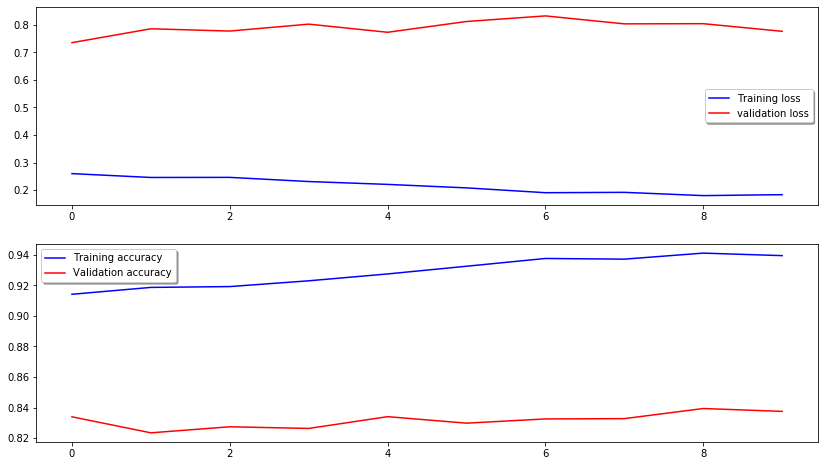

In [104]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1,figsize = (14,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [107]:
loss_history = [2.2452,1.8279,1.4665,1.1827,0.9582,0.7802,0.6559,0.5817,0.4974,0.4513,0.3979,0.3553,0.3256,0.3026,0.2866]\
            +history.history['loss']
val_loss_history = [1.9923,1.5538,1.2601,1.0854,0.9150,0.8195,0.7747,0.7900,0.9268,0.6967,0.7290,0.7141,0.7139,0.7324,0.7324]\
            +history.history['val_loss']
acc_history = [0.1978,0.3602,0.4912,0.5937,0.6737,0.7305,0.7744,0.8030,0.8333,0.8490,0.8668,0.8829,0.8916,0.8990,0.9071]\
            +history.history['accuracy']
val_acc_history = [0.2899,0.4855,0.5852,0.6482,0.7093,0.7405,0.7579,0.7631,0.7486,0.8050,0.7990,0.8068,0.8179,0.8226,0.8239]\
            +history.history['val_accuracy']
print(len(loss_history),len(val_loss_history),len(acc_history),len(val_acc_history))

25 25 25 25


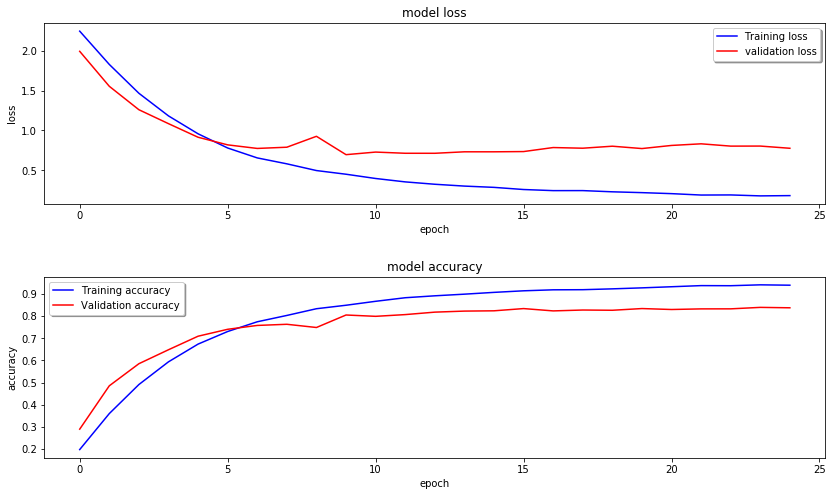

In [135]:

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1,figsize = (14,8))
ax[0].plot(loss_history, color='b', label="Training loss")
ax[0].plot(val_loss_history, color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].plot(acc_history, color='b', label="Training accuracy")
ax[1].plot(val_acc_history, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.subplots_adjust(hspace = 0.4)
plt.show()

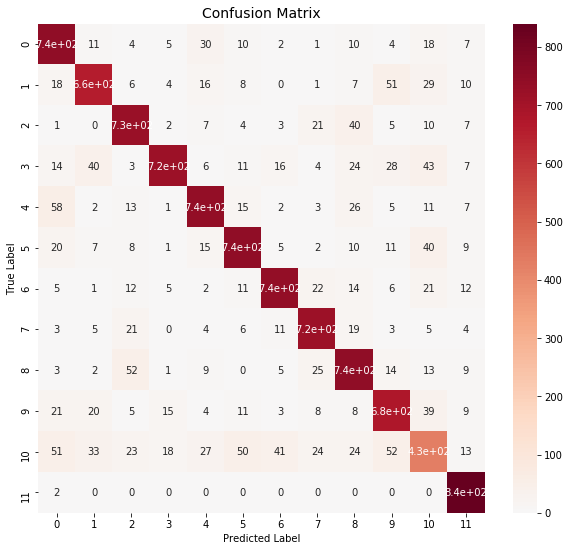

In [117]:
# confusion matrix
# Predict the values from the validation dataset
Y_pred = model.predict(test_wav)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_label,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plt.figure(figsize=(10,9))
sns.heatmap(confusion_mtx, cmap='RdBu_r', annot=True,  center=0.0)
plt.title("Confusion Matrix",fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [118]:
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

<a id='ref' />

# ref

## old version

In [119]:
#Conv1D Model
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model2 = tf.keras.Model(input_tensor, output_tensor)

model2.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])


In [120]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3995, 8)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3995, 8)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1994, 16)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1994, 16)          0   

### Train!

In [121]:
history2 = model2.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=10,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/10
40496/40496 [==============================] - 236s 6ms/sample - loss: 2.3941 - accuracy: 0.1393 - val_loss: 2.3327 - val_accuracy: 0.1679
Epoch 2/10
40496/40496 [==============================] - 215s 5ms/sample - loss: 2.2315 - accuracy: 0.1998 - val_loss: 2.1892 - val_accuracy: 0.2364
Epoch 3/10
40496/40496 [==============================] - 211s 5ms/sample - loss: 2.0776 - accuracy: 0.2438 - val_loss: 2.0856 - val_accuracy: 0.2618
Epoch 4/10
40496/40496 [==============================] - 213s 5ms/sample - loss: 1.9206 - accuracy: 0.3001 - val_loss: 1.9288 - val_accuracy: 0.3107
Epoch 5/10
40496/40496 [==============================] - 213s 5ms/sample - loss: 1.7632 - accuracy: 0.3544 - val_loss: 1.8723 - val_accuracy: 0.3271
Epoch 6/10
40496/40496 [==============================] - 212s 5ms/sample - loss: 1.6677 - accuracy: 0.3857 - val_loss: 1.7568 - val_accuracy: 0.3799
Epoch 7/10
40496/40496 [==========================

In [122]:
history3 = model2.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=20,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/20
40496/40496 [==============================] - 225s 6ms/sample - loss: 1.3814 - accuracy: 0.5072 - val_loss: 1.4730 - val_accuracy: 0.4909
Epoch 2/20
40496/40496 [==============================] - 223s 5ms/sample - loss: 1.3227 - accuracy: 0.5329 - val_loss: 1.3853 - val_accuracy: 0.5393
Epoch 3/20
40496/40496 [==============================] - 221s 5ms/sample - loss: 1.2751 - accuracy: 0.5508 - val_loss: 1.3658 - val_accuracy: 0.5395
Epoch 4/20
40496/40496 [==============================] - 220s 5ms/sample - loss: 1.2306 - accuracy: 0.5685 - val_loss: 1.3464 - val_accuracy: 0.5571
Epoch 5/20
40496/40496 [==============================] - 210s 5ms/sample - loss: 1.1928 - accuracy: 0.5887 - val_loss: 1.3309 - val_accuracy: 0.5545
Epoch 6/20
40496/40496 [==============================] - 228s 6ms/sample - loss: 1.1626 - accuracy: 0.5982 - val_loss: 1.1872 - val_accuracy: 0.6097
Epoch 7/20
40496/40496 [==========================

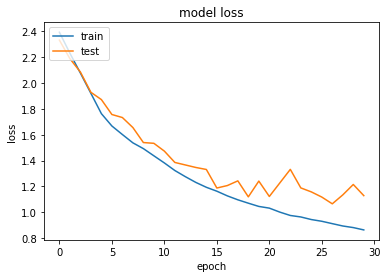

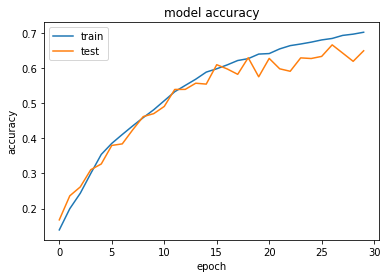

In [133]:
# summarize history for loss
plt.plot(history2.history['loss']+history3.history['loss'])
plt.plot(history2.history['val_loss']+history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['accuracy']+history3.history['accuracy'])
plt.plot(history2.history['val_accuracy']+history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()